In [1]:
import pandas as pd
import plotly.express as px
import torch
from einops import rearrange
import torch
import tqdm

In [2]:
from mamba_lens import HookedMamba
model = HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')
torch.set_grad_enabled(False)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [80]:
def get_pad_token(tokenizer):
    return model.tokenizer.encode(model.tokenizer.pad_token, add_special_tokens=False)[0]

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)
    

def eval_debug(model, data, correct, incorrect, constrain_to_answers, **kwargs):
    for data_i in range(correct.size()[0]):
        input = model.tokenizer.decode(data[data_i])
        top_k = 2
        logits = model.forward(input, **kwargs)[0,-1]
        correct_answers = correct[data_i]
        incorrect_answers = incorrect[data_i]
        if constrain_to_answers:
            only_consider_answer_logits = torch.full(logits.size(), fill_value=-torch.inf, device=model.cfg.device)
            only_consider_answer_logits[correct_answers] = logits[correct_answers]
            only_consider_answer_logits[incorrect_answers] = logits[incorrect_answers]
            logits = only_consider_answer_logits
        prs = torch.nn.functional.softmax(logits, dim=0)
        top = torch.argsort(-logits)[:top_k]
        printed = False
        printed_prompt = False
        for i, tok in enumerate(top):
            if not i == 0 and tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  correct top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
                #print("correct")
                #print(f"token {model.tokenizer.decode([tok])} logit {logits[tok]} prs {prs[tok]}")
            elif i == 0 and not tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  incorrect top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
            if tok in correct_answers:
                break
        if printed:
            print()

def eval(model, data, correct, incorrect, constrain_to_answers, **kwargs):
        num_examples = correct.size()[0]
        logits = model(data, **kwargs)[:,-1]
        pad = get_pad_token(tokenizer=model.tokenizer)
        logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

        n_data, n_correct = correct.size()
        n_data, n_incorrect = incorrect.size()

        if constrain_to_answers:
            # [n_data, n_correct]
            correct_logits = index_into(logits, correct)
            # [n_data, n_incorrect]
            incorrect_logits = index_into(logits, incorrect)
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            num_correct = torch.sum(biggest[:,0] < n_correct)
    
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
        else:
            prs = torch.nn.functional.softmax(logits, dim=1)
            # [n_data, n_correct]
            correct_prs = index_into(prs, correct)
            # [n_data, n_incorrect]
            incorrect_prs = index_into(prs, incorrect)
            # [n_data, 1]
            top_tokens = torch.topk(logits, 1, dim=1).indices
            # [n_data, n_correct]
            in_correct = top_tokens == correct
            # [n_data]
            has_any_correct = torch.any(in_correct, dim=1)
            # [1]
            num_correct = torch.sum(has_any_correct)
    
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs.sum(dim=1)).item(), torch.mean(incorrect_prs.sum(dim=1)).item(), num_correct.item()/float(n_data)

def add_padding_answers(tokenizer, answers):
    longest_len = len(max(answers, key=lambda x: len(x)))
    padded_answers = []
    pad_token = get_pad_token(tokenizer=tokenizer)
    for answer in answers:
        padded_answers.append(answer + [pad_token]*(longest_len-len(answer)))
    return padded_answers

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 3:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_correct), device=model.cfg.device)
        batched_incorrect = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_incorrect), device=model.cfg.device)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

def bar_chart(data, x_labels, y_label, title, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

In [137]:
## Generate data

from docstring import docstring_prompt_generator_function
from importlib import reload
import test_data
reload(test_data)
from test_data import IOI_generator, BABA_TEMPLATES, greater_than_data_generator, ABC_TEMPLATES, copy_generator

out_acc = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs_correct = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs_incorrect = torch.zeros([model.cfg.n_layers], device=model.cfg.device)

num_examples = 100

seed = 27
valid_seed = 37
test_seed = 47

data_type = 'copy'

constrain_to_answers = True

if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=seed)
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=valid_seed)
    test_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=test_seed)
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)
    test_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=test_seed)
elif data_type == 'greater than':
    constrain_to_answers = False
    data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    valid_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
    test_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed)
elif data_type == 'copy':
    constrain_to_answers = False
    copy_seq_len = 4
    data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=seed)
    valid_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=valid_seed)
    test_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=test_seed)

print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("\n\nvalid\n")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)
print("\n\ntest")
tbatched_data, tbatched_correct, tbatched_incorrect = get_batched_data(test_data)



data
 hockeySEQUENTIAL polyrating hockeySEQUENTIAL poly ['rating'] ['<|endoftext|>']
 marchinginguishMagn bride marchinginguishMagn [' bride'] ['<|endoftext|>']
 Determine mediationAsh bandwidth Determine mediationAsh [' bandwidth'] ['<|endoftext|>']


valid

anciesellarUsedrewanciesellarUsed ['rew'] ['<|endoftext|>']
SR ARE SinceicatedSR ARE Since ['icated'] ['<|endoftext|>']
Level Milanrak cultivLevel Milanrak [' cultiv'] ['<|endoftext|>']


test
RegisterCALeda MilkRegisterCALeda [' Milk'] ['<|endoftext|>']
 alignovirus fringe
 alignovirus fringe ['\n'] ['<|endoftext|>']
ites Bach unauthorized Centerites Bach unauthorized [' Center'] ['<|endoftext|>']


In [135]:
## Run the layer removal experiments
pr_is_relative = constrain_to_answers
relative_str = ' relative ' if constrain_to_answers else ' '

print(f"constraining output to answers? {constrain_to_answers}")

history = []
history_stats = []
layers_to_remove = []
while len(layers_to_remove) < model.cfg.n_layers:
    base_layers = list(range(model.cfg.n_layers))


    for layer in layers_to_remove:
        base_layers.remove(layer)
    history.append(list(base_layers))
    
    correct, incorrect, acc = eval(model, vbatched_data, vbatched_correct, vbatched_incorrect,
                                      only_use_these_layers=base_layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    print(base_layers)
    
    for i, start_layer in tqdm.tqdm(enumerate(base_layers)):
        #layers = list(range(start_layer, end_layer+1))
        layers = list(base_layers)
        layers.remove(start_layer)

        
        correct, incorrect, acc = eval(model, batched_data, batched_correct, batched_incorrect,
                                      only_use_these_layers=layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc
        
    
    best_layer_to_remove = base_layers[torch.argsort(-out_acc[:len(base_layers)])[0]]
    print("removing layer", best_layer_to_remove)
    layer_names = [f'layer {x}' for x in base_layers]
    layers_to_remove.append(best_layer_to_remove)

history_stats = torch.tensor(history_stats)

constraining output to answers? False
correct pr 0.9416652321815491 incorrect pr 0.022318443283438683 accuracy 0.98
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


48it [00:12,  3.88it/s]


removing layer 44
correct pr 0.9301146268844604 incorrect pr 0.04429662972688675 accuracy 1.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


47it [00:11,  3.93it/s]


removing layer 1
correct pr 0.9083428978919983 incorrect pr 0.06023723632097244 accuracy 0.98
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


46it [00:11,  4.01it/s]


removing layer 2
correct pr 0.865223228931427 incorrect pr 0.10106740891933441 accuracy 0.97
[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


45it [00:11,  4.09it/s]


removing layer 6
correct pr 0.8724905252456665 incorrect pr 0.09306599199771881 accuracy 0.99
[0, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


44it [00:10,  4.17it/s]


removing layer 7
correct pr 0.8958735466003418 incorrect pr 0.06687082350254059 accuracy 0.98
[0, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


43it [00:10,  4.25it/s]


removing layer 3
correct pr 0.888591468334198 incorrect pr 0.06958553940057755 accuracy 0.99
[0, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


42it [00:09,  4.35it/s]


removing layer 5
correct pr 0.8801690340042114 incorrect pr 0.06894385814666748 accuracy 0.99
[0, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


41it [00:09,  4.45it/s]


removing layer 8
correct pr 0.8857265114784241 incorrect pr 0.06659113615751266 accuracy 0.98
[0, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


40it [00:08,  4.56it/s]


removing layer 10
correct pr 0.8830859065055847 incorrect pr 0.07275109738111496 accuracy 0.99
[0, 4, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


39it [00:08,  4.66it/s]


removing layer 13
correct pr 0.8414223790168762 incorrect pr 0.10089991241693497 accuracy 0.97
[0, 4, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


38it [00:07,  4.77it/s]


removing layer 14
correct pr 0.8005134463310242 incorrect pr 0.11747725307941437 accuracy 0.98
[0, 4, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


37it [00:07,  4.91it/s]


removing layer 4
correct pr 0.8006725907325745 incorrect pr 0.11583003401756287 accuracy 0.98
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47]


36it [00:07,  5.04it/s]


removing layer 37
correct pr 0.6978604197502136 incorrect pr 0.2063140869140625 accuracy 0.97
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47]


35it [00:06,  5.16it/s]


removing layer 30
correct pr 0.6720374822616577 incorrect pr 0.21041597425937653 accuracy 0.92
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47]


34it [00:06,  5.32it/s]


removing layer 27
correct pr 0.6629920601844788 incorrect pr 0.18776153028011322 accuracy 0.9
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47]


33it [00:06,  5.49it/s]


removing layer 35
correct pr 0.695491373538971 incorrect pr 0.15639548003673553 accuracy 0.93
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47]


32it [00:05,  5.63it/s]


removing layer 38
correct pr 0.6469871401786804 incorrect pr 0.15386182069778442 accuracy 0.91
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 36, 39, 40, 41, 42, 43, 45, 46, 47]


31it [00:05,  5.83it/s]


removing layer 32
correct pr 0.641823947429657 incorrect pr 0.12282224744558334 accuracy 0.9
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 39, 40, 41, 42, 43, 45, 46, 47]


30it [00:04,  6.03it/s]


removing layer 21
correct pr 0.5747432708740234 incorrect pr 0.12725624442100525 accuracy 0.88
[0, 9, 11, 12, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 39, 40, 41, 42, 43, 45, 46, 47]


29it [00:04,  6.22it/s]


removing layer 15
correct pr 0.5333713889122009 incorrect pr 0.2086137980222702 accuracy 0.88
[0, 9, 11, 12, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 39, 40, 41, 42, 43, 45, 46, 47]


28it [00:04,  6.42it/s]


removing layer 17
correct pr 0.5793988108634949 incorrect pr 0.17427322268486023 accuracy 0.89
[0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 39, 40, 41, 42, 43, 45, 46, 47]


27it [00:04,  6.64it/s]


removing layer 43
correct pr 0.6446154713630676 incorrect pr 0.15105655789375305 accuracy 0.91
[0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 39, 40, 41, 42, 45, 46, 47]


26it [00:03,  6.92it/s]


removing layer 39
correct pr 0.6292223334312439 incorrect pr 0.13182476162910461 accuracy 0.95
[0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]


25it [00:03,  7.19it/s]


removing layer 28
correct pr 0.6500760316848755 incorrect pr 0.11759068816900253 accuracy 0.92
[0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 24, 25, 26, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]


24it [00:03,  7.47it/s]


removing layer 24
correct pr 0.5662173628807068 incorrect pr 0.11292890459299088 accuracy 0.84
[0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 25, 26, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]


23it [00:02,  7.82it/s]


removing layer 18
correct pr 0.5793377757072449 incorrect pr 0.1464317888021469 accuracy 0.84
[0, 9, 11, 12, 16, 19, 20, 22, 23, 25, 26, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]


22it [00:02,  8.17it/s]


removing layer 9
correct pr 0.5326038002967834 incorrect pr 0.1770275980234146 accuracy 0.79
[0, 11, 12, 16, 19, 20, 22, 23, 25, 26, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]


21it [00:02,  8.54it/s]


removing layer 26
correct pr 0.4558819532394409 incorrect pr 0.18182574212551117 accuracy 0.73
[0, 11, 12, 16, 19, 20, 22, 23, 25, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]


20it [00:02,  8.93it/s]


removing layer 31
correct pr 0.5103229880332947 incorrect pr 0.1997438222169876 accuracy 0.74
[0, 11, 12, 16, 19, 20, 22, 23, 25, 29, 33, 34, 36, 40, 41, 42, 45, 46, 47]


19it [00:02,  9.32it/s]


removing layer 42
correct pr 0.4661678075790405 incorrect pr 0.2170390486717224 accuracy 0.67
[0, 11, 12, 16, 19, 20, 22, 23, 25, 29, 33, 34, 36, 40, 41, 45, 46, 47]


18it [00:01,  9.86it/s]


removing layer 23
correct pr 0.4013274312019348 incorrect pr 0.27964481711387634 accuracy 0.53
[0, 11, 12, 16, 19, 20, 22, 25, 29, 33, 34, 36, 40, 41, 45, 46, 47]


17it [00:01, 10.58it/s]


removing layer 33
correct pr 0.3405931890010834 incorrect pr 0.14059171080589294 accuracy 0.56
[0, 11, 12, 16, 19, 20, 22, 25, 29, 34, 36, 40, 41, 45, 46, 47]


16it [00:01, 11.08it/s]


removing layer 25
correct pr 0.31950706243515015 incorrect pr 0.11835645139217377 accuracy 0.47
[0, 11, 12, 16, 19, 20, 22, 29, 34, 36, 40, 41, 45, 46, 47]


15it [00:01, 11.95it/s]


removing layer 20
correct pr 0.37109375 incorrect pr 0.17692506313323975 accuracy 0.56
[0, 11, 12, 16, 19, 22, 29, 34, 36, 40, 41, 45, 46, 47]


14it [00:01, 12.70it/s]


removing layer 22
correct pr 0.33097606897354126 incorrect pr 0.2744859755039215 accuracy 0.47
[0, 11, 12, 16, 19, 29, 34, 36, 40, 41, 45, 46, 47]


13it [00:00, 13.52it/s]


removing layer 47
correct pr 0.18816085159778595 incorrect pr 0.1205839142203331 accuracy 0.28
[0, 11, 12, 16, 19, 29, 34, 36, 40, 41, 45, 46]


12it [00:00, 14.68it/s]


removing layer 46
correct pr 0.25393664836883545 incorrect pr 0.12683574855327606 accuracy 0.28
[0, 11, 12, 16, 19, 29, 34, 36, 40, 41, 45]


11it [00:00, 16.09it/s]


removing layer 40
correct pr 0.18899941444396973 incorrect pr 0.2514665424823761 accuracy 0.16
[0, 11, 12, 16, 19, 29, 34, 36, 41, 45]


10it [00:00, 17.71it/s]


removing layer 45
correct pr 0.10888675600290298 incorrect pr 0.18930891156196594 accuracy 0.09
[0, 11, 12, 16, 19, 29, 34, 36, 41]


9it [00:00, 19.57it/s]


removing layer 41
correct pr 0.0913357138633728 incorrect pr 0.19442707300186157 accuracy 0.09
[0, 11, 12, 16, 19, 29, 34, 36]


8it [00:00, 22.12it/s]


removing layer 29
correct pr 0.30809980630874634 incorrect pr 0.274895578622818 accuracy 0.34
[0, 11, 12, 16, 19, 34, 36]


7it [00:00, 25.10it/s]


removing layer 11
correct pr 0.19844909012317657 incorrect pr 0.7124673128128052 accuracy 0.18
[0, 12, 16, 19, 34, 36]


6it [00:00, 29.06it/s]


removing layer 19
correct pr 0.356290727853775 incorrect pr 0.6037721633911133 accuracy 0.37
[0, 12, 16, 34, 36]


5it [00:00, 34.52it/s]


removing layer 12
correct pr 0.1555977314710617 incorrect pr 0.2829076647758484 accuracy 0.15
[0, 16, 34, 36]


4it [00:00, 43.51it/s]


removing layer 16
correct pr 0.23211322724819183 incorrect pr 0.5234177112579346 accuracy 0.24
[0, 34, 36]


3it [00:00, 57.58it/s]


removing layer 34
correct pr 0.0862603634595871 incorrect pr 0.9050986766815186 accuracy 0.08
[0, 36]


2it [00:00, 82.48it/s]


removing layer 0
correct pr 0.05642598867416382 incorrect pr 0.3803967237472534 accuracy 0.06
[36]


1it [00:00, 148.50it/s]

removing layer 36


In [130]:
# pick something from the above output to test on an held out test set
# [0, 9, 17, 18, 21, 33, 39] ioi BABA_TEMPLATES[1] 0.86 (also [0, 9, 10, 17, 18, 21, 33, 39] 0.9)
# [0, 9, 10, 11, 14, 16, 19, 22, 33, 39] is from ABC_TEMPLATES
# [0, 12, 13, 14, 16, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 45] docstring 0.81
# [0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 44, 45] docstring
# [0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 24, 25, 26, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47] greater than
# [0, 2, 9, 10, 11, 12, 13, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47] copy
print(f"constraining output to answers? {constrain_to_answers}")
test_layers = [0, 9, 17, 18, 21, 33, 39]

correct, incorrect, acc = eval(model, tbatched_data, tbatched_correct, tbatched_incorrect,
                                  only_use_these_layers=test_layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
print()
print(f"test set eval results: correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
print()
eval_debug(model=model,
           data=tbatched_data, correct=tbatched_correct, incorrect=tbatched_incorrect,
           constrain_to_answers=constrain_to_answers,
           only_use_these_layers=test_layers, fast_ssm=True, fast_conv=True)


constraining output to answers? True

test set eval results: correct relative pr 0.8834324479103088 incorrect relative pr 0.11656749248504639 accuracy 0.88

prompt Then, Lauren and Philippine had a lot of fun at the store. Lauren gave a drink to
  incorrect top 0 token ' Lauren' logit -3.870558261871338 prs 0.9999974966049194
  correct top 1 token ' Philippine' logit -16.759098052978516 prs 2.5268357148888754e-06

prompt Then, Brooks and Joey had a lot of fun at the house. Joey gave a computer to
  incorrect top 0 token ' Joey' logit -8.86937141418457 prs 0.9994902610778809
  correct top 1 token ' Brooks' logit -16.450414657592773 prs 0.0005097688990645111

prompt Then, Rey and Kathleen had a lot of fun at the store. Kathleen gave a snack to
  incorrect top 0 token ' Kathleen' logit -22.520671844482422 prs 0.9999997615814209
  correct top 1 token ' Rey' logit -37.748329162597656 prs 2.4361966666219814e-07

prompt Then, Olive and Kyle had a lot of fun at the restaurant. Kyle gave a snac

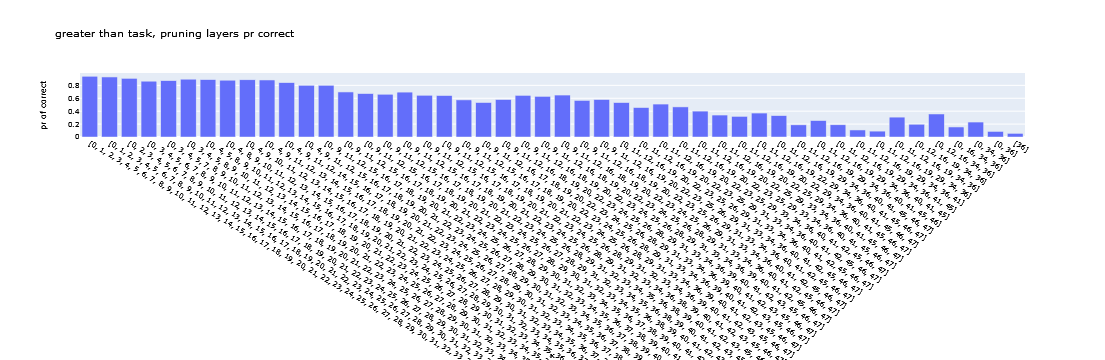

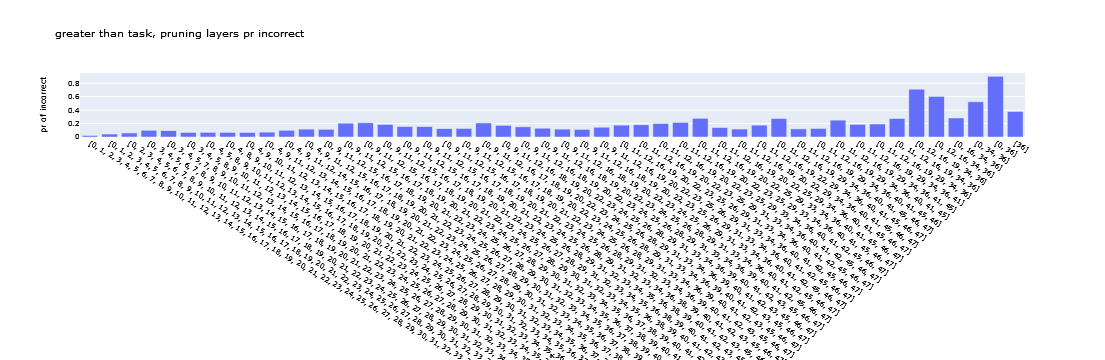

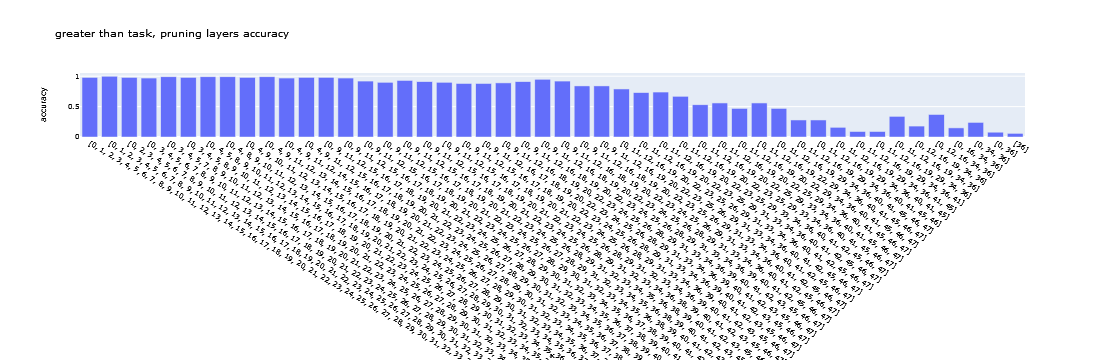

In [136]:
bar_chart(history_stats[:,0], x_labels=[str(x) for x in history], y_label=f'{relative_str}pr of correct', title=f"{data_type} task, pruning layers{relative_str}pr correct", font_size=7)
bar_chart(history_stats[:,1], x_labels=[str(x) for x in history], y_label=f'{relative_str}pr of incorrect', title=f"{data_type} task, pruning layers{relative_str}pr incorrect", font_size=7)
bar_chart(history_stats[:,2], x_labels=[str(x) for x in history], y_label='accuracy', title=f"{data_type} task, pruning layers accuracy", font_size=7)

In [ ]:
'''docstring:
def shape(self, format, number, log, item, filename, run):
    """working adult travel

    :param log: store impact
    :param item: stand screen
    :param
'''

'''IOI
Then, Brooks and Joey had a lot of fun at the house. Joey gave a computer to
'''

'''greater than
The process lasted from the year 1548 to 15
'''

'''copy
anciesellarUsedrewanciesellarUsed ['rew']
SR ARE SinceicatedSR ARE Since ['icated']
Level Milanrak cultivLevel Milanrak [' cultiv']
'''
